# EstateWise Chapel Hill Real Estate Analysis & Gemini Chat CLI

Welcome to the EstateWise Colab notebook, where we combine advanced data science techniques with Google’s Gemini API to explore and interact with Chapel Hill’s real estate market. Whether you’re digging into trends, clustering similar homes, or simply chatting with our AI concierge, this notebook has you covered.

## This notebook covers

1. **Install dependencies**  
2. **Mount Google Drive**
3. **Load Properties Data**
4. **Clean & wrangle data**  
5. **Exploratory Data Analysis (EDA)**  
6. **PCA / t-SNE + k-Means clustering**  
7. **Cluster summaries**  
8. **Interactive geospatial visualizations**  
   - Clustered circle markers by K-Means group  
   - Home-type layers with address search  
   - Count-based MarkerCluster view  
89. **Interactive Google Gemini CLI**  
   - Agentic AI decides when to fetch property data  
   - Five-expert ensemble with master-agent merge (MoE - Mixture of Experts Pipeline)
   - Type questions & get tailored Chapel Hill home recommendations in real time!

<p align="center">
  <img src="https://img.shields.io/badge/Python-3.11-blue?style=flat-square&logo=python&logoColor=white" alt="Python"/>
  <img src="https://img.shields.io/badge/Jupyter-Notebook-orange?style=flat-square&logo=jupyter&logoColor=white" alt="Jupyter Notebook"/>
  <img src="https://img.shields.io/badge/pandas-Data%20Wrangling-150458?style=flat-square&logo=pandas&logoColor=white" alt="pandas"/>
  <img src="https://img.shields.io/badge/NumPy-Numerical%20Computing-013243?style=flat-square&logo=numpy&logoColor=white" alt="NumPy"/>
  <img src="https://img.shields.io/badge/scikit--learn-ML-F7931E?style=flat-square&logo=scikitlearn&logoColor=white" alt="scikit-learn"/>
  <img src="https://img.shields.io/badge/Matplotlib-Visualization-11557C?style=flat-square&logo=matplotlib&logoColor=white" alt="Matplotlib"/>
  <img src="https://img.shields.io/badge/Seaborn-Statistical%20Viz-76B5C5?style=flat-square&logo=seaborn&logoColor=white" alt="Seaborn"/>
  <img src="https://img.shields.io/badge/Folium-Mapping-00A5CF?style=flat-square&logo=mapbox&logoColor=white" alt="Folium"/>
  <img src="https://img.shields.io/badge/Pinecone-Vector%20DB-663399?style=flat-square&logo=pinecone&logoColor=white" alt="Pinecone"/>
  <img src="https://img.shields.io/badge/Google%20Gemini-AI-4285F4?style=flat-square&logo=google&logoColor=white" alt="Google Gemini"/>
  <img src="https://img.shields.io/badge/python--dotenv-Configuration-3C873A?style=flat-square&logo=dotenv&logoColor=white" alt="python-dotenv"/>
</p>

> To run the code in this notebook, download the notebook and then upload it to [Google Colab](https://colab.research.google.com).

# 1. Install Depenencies & Setup

In [ ]:
# 1. Install Dependencies
!pip install --upgrade pandas numpy scikit-learn matplotlib seaborn google-generativeai python-dotenv

# 2. Imports & Mount Google Drive

In [19]:
# 2. Imports & Mount Drive
import os, glob, json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Google Gemini client
import google.generativeai as genai
from dotenv import load_dotenv

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 2.1 Configure Paths & API Key

- Point `path488` to your Zillow JSON folder in Drive  
- Set `GOOGLE_API_KEY` in Colab’s environment (Settings → Secrets)

In [20]:
# Path to folder containing your Zillow JSONs
path488 = '/content/drive/MyDrive/COMP-488/'
zillowfiles = glob.glob(path488 + 'Zillow*.json')
# Keep only 2025 files
zillow25 = [f for f in zillowfiles if '2025' in f]
print("Found 2025 JSON files:", zillow25)

Found 2025 JSON files: ['/content/drive/MyDrive/COMP-488/Zillow-March2025-dataset_part0.json']


## 3. Load & Concatenate 2025 Data

In [21]:
dfs = []
for fp in zillow25:
    with open(fp, 'r', encoding='utf8') as f:
        arr = json.load(f)
    dfs.append(pd.DataFrame(arr))
df_raw = pd.concat(dfs, ignore_index=True)
print(f"Raw 2025 records: {len(df_raw):,}")

Raw 2025 records: 467


## 4. Data Cleaning & Wrangling

- Keep only relevant fields  
- Apply safe parsing and drop invalid entries  

In [22]:
# 4.1 Helpers & field list
def safe_str(val, fallback="Unknown"):
    return val.strip() if isinstance(val, str) and val.strip() else fallback

def safe_num(val, fallback=0, mn=None, mx=None):
    try:
        n = float(val)
    except:
        return fallback
    if mn is not None and n < mn:
        return fallback
    if mx is not None and n > mx:
        return fallback
    return n

keep = [
    "zpid","address","city","state","bedrooms","bathrooms",
    "price","yearBuilt","livingArea","latitude","longitude",
    "homeType","listingDataSource","description"
]

In [28]:
# 4.2 Clean records
import pandas as pd
import numpy as np
import json

# Helper functions
def safe_num(val, default=0, min_val=None, max_val=None):
    """
    Convert a value to float, applying bounds and default on failure or missing.
    """
    try:
        if pd.isna(val):
            return default
    except:
        pass
    try:
        # strip commas, whitespace
        num = float(str(val).replace(",", "").strip())
    except:
        return default
    if (min_val is not None and num < min_val) or (max_val is not None and num > max_val):
        return default
    return num

def safe_int(val, default=0, min_val=None, max_val=None):
    """
    Convert to int safely via safe_num, then cast.
    """
    num = safe_num(val, default, min_val, max_val)
    return int(round(num))

def safe_float(val, default=0.0, min_val=None, max_val=None, step=0.5):
    """
    Convert to float safely via safe_num, then round to nearest step (e.g. 0.5 for bathrooms).
    """
    num = safe_num(val, default, min_val, max_val)
    # round to nearest step
    return round(num / step) * step

def safe_str(val, default="Unknown"):
    """
    Ensure string, JSON-serialize dicts/lists, default if missing/empty.
    """
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return default
    if isinstance(val, (dict, list)):
        try:
            return json.dumps(val)
        except:
            return default
    s = str(val).strip()
    return s if s else default

# 4.2 Clean records (improved)
current_year = pd.Timestamp.now().year
records = []

for r in df_raw[keep].to_dict('records'):
    # normalize address field if it's a JSON string
    addr_field = r.get("address")
    if isinstance(addr_field, str):
        try:
            addr = json.loads(addr_field)
        except:
            addr = {}
    else:
        addr = addr_field or {}

    # safe extraction
    zpid = safe_int(r.get("zpid"), default=0)
    street = safe_str(addr.get("streetAddress"), default="")
    city   = safe_str(addr.get("city") or r.get("city"), default="")
    state  = safe_str(addr.get("state") or r.get("state"), default="")
    zipcode= safe_str(addr.get("zipcode"), default="")

    # skip if essential address components missing
    if zpid == 0 or not street or not city or not state or not zipcode:
        continue

    # numeric fields
    bedrooms  = safe_int(r.get("bedrooms"), default=0, min_val=0, max_val=20)
    bathrooms = safe_float(r.get("bathrooms"), default=0.0, min_val=0, max_val=20, step=0.5)
    price     = safe_num(r.get("price"), default=0, min_val=10000, max_val=1e8)

    # handle yearBuilt bounds
    year_val = safe_int(r.get("yearBuilt"), default=0)
    if year_val < 1800 or year_val > current_year + 1:
        yearBuilt = 0
    else:
        yearBuilt = year_val

    livingArea = safe_num(r.get("livingArea"), default=0, min_val=100, max_val=20000)

    # geolocation
    latitude  = safe_num(r.get("latitude"), default=0.0, min_val=-90, max_val=90)
    longitude = safe_num(r.get("longitude"), default=0.0, min_val=-180, max_val=180)

    # categorical/text fields
    homeType           = safe_str(r.get("homeType"))
    listingDataSource  = safe_str(r.get("listingDataSource"))
    description        = safe_str(r.get("description"), default="No description provided.")

    records.append({
        "zpid": zpid,
        "street": street,
        "city": city,
        "state": state,
        "zipcode": zipcode,
        "bedrooms": bedrooms,
        "bathrooms": bathrooms,
        "price": price,
        "yearBuilt": yearBuilt,
        "livingArea": livingArea,
        "latitude": latitude,
        "longitude": longitude,
        "homeType": homeType,
        "listingDataSource": listingDataSource,
        "description": description,
    })

# create DataFrame
df = pd.DataFrame(records)
print(f"Cleaned records: {len(df):,}")
df.head()


Cleaned records: 453


,zpid,street,city,state,zipcode,bedrooms,bathrooms,price,yearBuilt,livingArea,latitude,longitude,homeType,listingDataSource,description
0,50032766,302 Orchard Ln #92,Carrboro,NC,27510,5,2.5,764100.0,1991,3013.0,35.897522,-79.077890,SINGLE_FAMILY,Legacy,This 3013 square foot single family home has 5...
1,50037322,232 McCauley St UNIT A,Chapel Hill,NC,27516,8,6.0,829100.0,1927,3217.0,35.907510,-79.057396,APARTMENT,Legacy,This 3217 square foot apartment home has 8 bed...
2,251696953,2034 Foxwood Farm Trl,Chapel Hill,NC,27516,4,3.5,965600.0,1997,3009.0,35.960842,-79.143480,SINGLE_FAMILY,Legacy,This 3009 square foot single family home has 4...
3,251557517,1509 Partridgeberry Rd #A,Chapel Hill,NC,27516,4,2.0,453400.0,1992,1658.0,35.894210,-79.179276,SINGLE_FAMILY,Legacy,This 1658 square foot single family home has 4...
4,50037263,308 Ransom St,Chapel Hill,NC,27516,2,1.0,701600.0,1942,1120.0,35.906284,-79.057724,APARTMENT,Legacy,"In-town bungalow, blocks from campus & Frankli..."


## 5. Exploratory Data Analysis (EDA)

In [29]:
# 5.1 Overview
print(df.dtypes, "\n")
print("Missing values:\n", df.isna().sum())

# 5.2 Summary stats
display(df.describe().T)


zpid                   int64
street                object
city                  object
state                 object
zipcode               object
bedrooms               int64
bathrooms            float64
price                float64
yearBuilt              int64
livingArea           float64
latitude             float64
longitude            float64
homeType              object
listingDataSource     object
description           object
dtype: object 

Missing values:
 zpid                 0
street               0
city                 0
state                0
zipcode              0
bedrooms             0
bathrooms            0
price                0
yearBuilt            0
livingArea           0
latitude             0
longitude            0
homeType             0
listingDataSource    0
description          0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
zpid,453.0,1.020293e+08,1.235820e+08,4.996870e+07,5.003983e+07,6.007135e+07,9.818678e+07,2.070114e+09
bedrooms,453.0,2.803532e+00,1.510666e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01
bathrooms,453.0,2.338852e+00,1.359770e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,8.000000e+00
price,453.0,7.862020e+05,1.739358e+06,0.000000e+00,3.120000e+05,5.248000e+05,8.321000e+05,3.161020e+07
yearBuilt,453.0,1.899680e+03,4.091650e+02,0.000000e+00,1.977000e+03,1.990000e+03,2.000000e+03,2.023000e+03
livingArea,453.0,2.164949e+03,1.835977e+03,0.000000e+00,1.088000e+03,1.584000e+03,2.802000e+03,1.574800e+04
latitude,453.0,3.568180e+01,2.917158e+00,0.000000e+00,3.589807e+01,3.592639e+01,3.594496e+01,3.624017e+01
longitude,453.0,-7.854880e+01,6.428327e+00,-8.371497e+01,-7.906650e+01,-7.904431e+01,-7.901911e+01,0.000000e+00


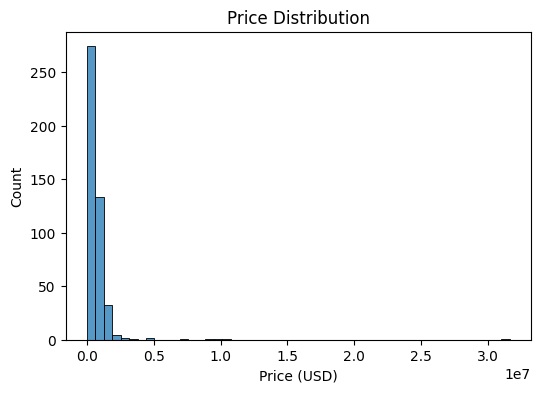

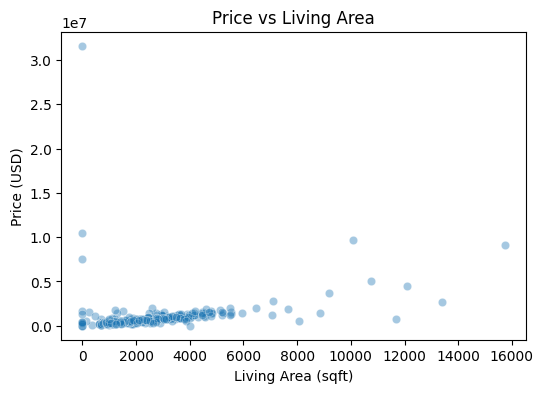

In [30]:
# 5.3 Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price (USD)")
plt.show()

# 5.4 Price vs Living Area
plt.figure(figsize=(6,4))
sns.scatterplot(x="livingArea", y="price", data=df, alpha=0.4)
plt.title("Price vs Living Area")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Price (USD)")
plt.show()


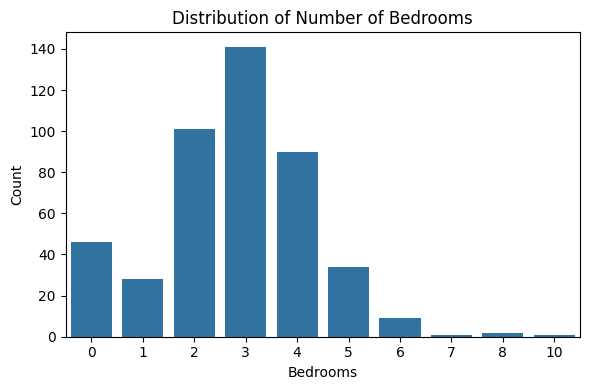

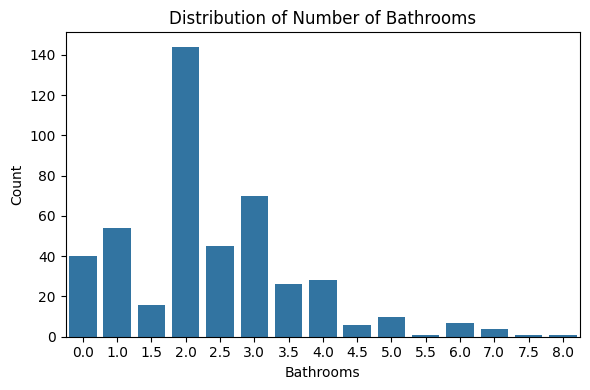

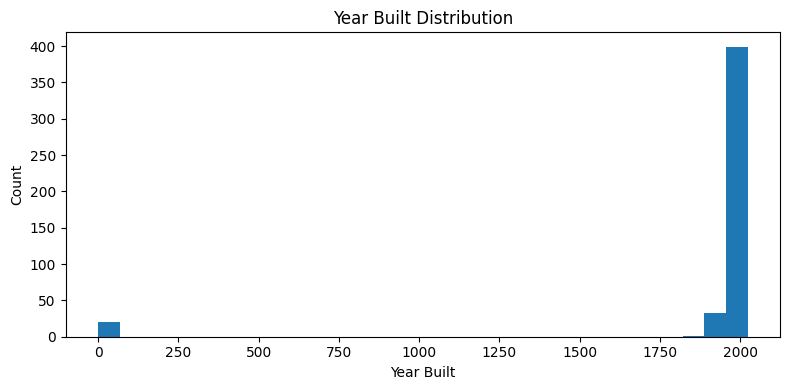

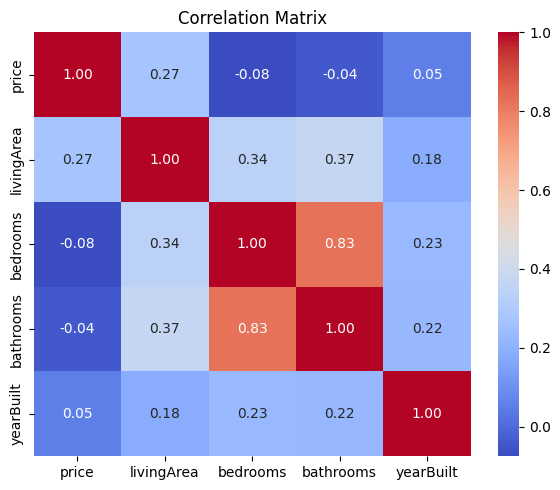

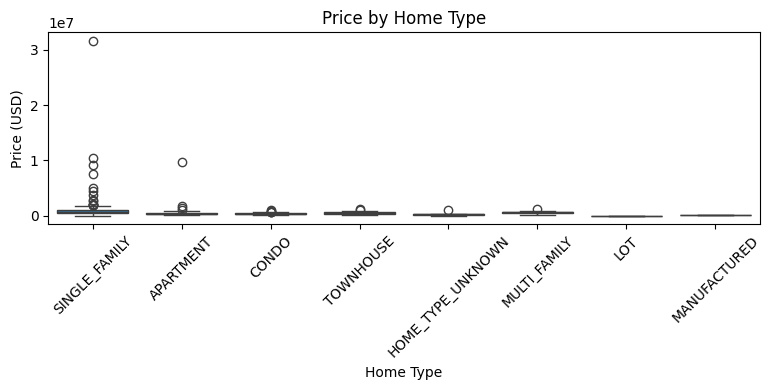

Top 10 Most Expensive Properties:
                address      price  bedrooms  bathrooms  livingArea  yearBuilt      homeType
Chapel Hill, NC, 27517 31610200.0         0        0.0         0.0       2008 SINGLE_FAMILY
Chapel Hill, NC, 27514 10506000.0         0        0.0         0.0       1975 SINGLE_FAMILY
Chapel Hill, NC, 27516  9681000.0         0        0.0     10098.0       1972     APARTMENT
Chapel Hill, NC, 27514  9110100.0         0        0.0     15748.0       2003 SINGLE_FAMILY
Chapel Hill, NC, 27516  7504000.0         0        0.0         0.0       2007 SINGLE_FAMILY
Chapel Hill, NC, 27516  5000000.0         2        1.0     10766.0       1952 SINGLE_FAMILY
Chapel Hill, NC, 27517  4430500.0         0        0.0     12081.0       1997 SINGLE_FAMILY
Chapel Hill, NC, 27514  3731000.0         0        0.0      9192.0       1990 SINGLE_FAMILY
Chapel Hill, NC, 27517  2803000.0         6        7.0      7096.0       1989 SINGLE_FAMILY
Chapel Hill, NC, 27514  2655400.0         0  

In [31]:
if 'address' not in df.columns:
    def make_address(row):
        street = row.get('streetAddress', '') or ''
        city   = row.get('city', '') or ''
        state  = row.get('state', '') or ''
        zipc   = row.get('zipcode', '') or ''
        parts = [street, city, state, zipc]
        return ", ".join([p for p in parts if p])
    df['address'] = df.apply(make_address, axis=1)

# 5.5 Bedrooms distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="bedrooms", data=df)
plt.title("Distribution of Number of Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.6 Bathrooms distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="bathrooms", data=df)
plt.title("Distribution of Number of Bathrooms")
plt.xlabel("Bathrooms")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.7 Year Built distribution
plt.figure(figsize=(8, 4))
plt.hist(df["yearBuilt"].dropna(), bins=30)
plt.title("Year Built Distribution")
plt.xlabel("Year Built")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.8 Correlation matrix heatmap
corr = df[["price", "livingArea", "bedrooms", "bathrooms", "yearBuilt"]].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 5.9 Boxplot of Price by Home Type
plt.figure(figsize=(8, 4))
sns.boxplot(x="homeType", y="price", data=df)
plt.title("Price by Home Type")
plt.xlabel("Home Type")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.10 Top 10 most expensive properties
top10 = df.nlargest(10, "price")[["address", "price", "bedrooms", "bathrooms", "livingArea", "yearBuilt", "homeType"]]
print("Top 10 Most Expensive Properties:\n", top10.to_string(index=False))

## 6. PCA, t-SNE & k‑Means Clustering

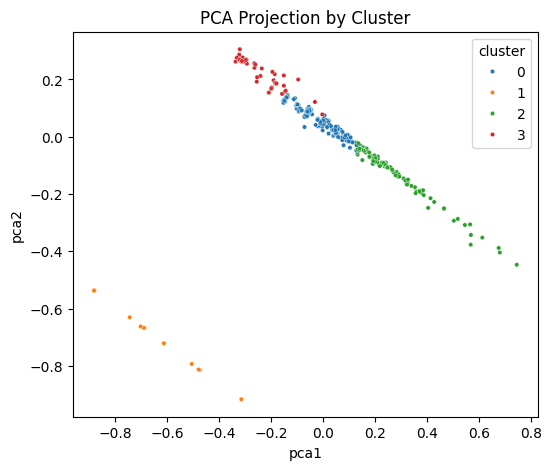

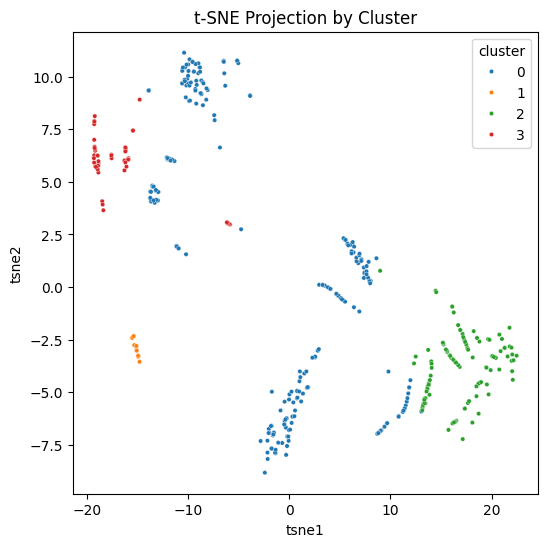

In [32]:
# 6.1 Impute & Normalize features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

features = ["price", "bedrooms", "bathrooms", "livingArea", "yearBuilt"]

# 1) Impute missing values with column means
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(df[features])

# 2) Scale to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_imputed)

# 6.2 PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
df["pca1"], df["pca2"] = pca.fit_transform(X).T

# 6.3 t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
df["tsne1"], df["tsne2"] = tsne.fit_transform(X).T

# 6.4 k-Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

# Visualize clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df, palette="tab10", s=10)
plt.title("PCA Projection by Cluster")
plt.show()

plt.figure(figsize=(6,6))
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", data=df, palette="tab10", s=10)
plt.title("t-SNE Projection by Cluster")
plt.show()


## 7. Cluster Summaries

In [33]:
cluster_summary = df.groupby("cluster").agg(
    count=("zpid","size"),
    avg_price=("price","mean"),
    avg_sqft=("livingArea","mean"),
    avg_year=("yearBuilt","mean")
).round(2).reset_index()
cluster_summary

,cluster,count,avg_price,avg_sqft,avg_year
0,0,265,488278.11,1597.02,1985.33
1,1,20,375825.00,645.55,0.00
2,2,112,1003205.36,3575.18,1994.75
3,3,56,1908576.79,2574.66,1982.68


## 8. Interactive Geospatial Visualization of Listings

In this section we’ll build three different interactive maps in Colab to explore our cleaned and clustered real estate listings:

1. **Clustered Circle Markers with Layers**  
   - Centered on Chapel Hill, NC  
   - Fullscreen, measurement tool, and minimap controls  
   - One FeatureGroup per cluster (Cluster 0…Cluster 3), toggleable via the layer control  
   - Circle markers colored by cluster, with popups showing address, price, beds/baths, living area, year built  

2. **Home-Type Map with Search Bar**  
   - One FeatureGroup per `homeType` (e.g. Single Family, Condo)  
   - Search plugin to lookup any property by its full address  
   - Toggle layers for each home type via the layer control  
   - Popups and tooltips include type, price, and basic specs  

3. **Count-based MarkerCluster**  
   - MarkerCluster with custom div icons that display the number of listings in each cluster  
   - No heatmap—clusters simply show counts, and clicking expands individual markers with popups  
   - Layer control to toggle the count-cluster overlay  

Each map leverages **Folium** and supports intuitive pan/zoom, layer toggling, and rich popups/tooltips to help you visually explore spatial patterns in Chapel Hill real estate data. Simply run the corresponding code cells below to render each interactive map in your notebook.


In [36]:
import folium
from folium.plugins import MarkerCluster, HeatMap, MiniMap, Fullscreen, MeasureControl

# 8. Interactive Geospatial Visualization of Listings (Fixed color mapping)

# 8.1 Center map on Chapel Hill, NC
chapel_hill_coords = [35.9132, -79.0558]
m = folium.Map(
    location=chapel_hill_coords,
    zoom_start=13,
    tiles='CartoDB positron',
    control_scale=True
)

# 8.2 Add Fullscreen and Measure controls
Fullscreen(position='topright').add_to(m)
MeasureControl(position='topright', primary_length_unit='feet').add_to(m)

# 8.3 Add a minimap inset
MiniMap(toggle_display=True, position='bottomright').add_to(m)

# 8.4 Prepare a color palette for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige']
cluster_colors = {c: colors[c % len(colors)] for c in sorted(df['cluster'].unique())}

# 8.5 Create feature groups for each cluster
cluster_groups = {}
for c, color in cluster_colors.items():
    fg = folium.FeatureGroup(name=f"Cluster {c}", show=(c == 0))
    cluster_groups[c] = fg
    m.add_child(fg)

# 8.6 Add markers for each listing
for _, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    if pd.isna(lat) or pd.isna(lon):
        continue
    c = row['cluster']
    color = cluster_colors[c]
    popup_html = (
        f"<strong>{row['street']}, {row['city']}</strong><br>"
        f"Price: ${row['price']:,}<br>"
        f"Beds: {row['bedrooms']}, Baths: {row['bathrooms']}<br>"
        f"Area: {row['livingArea']} sqft, Year: {row['yearBuilt']}<br>"
        f"Cluster: {c}"
    )
    tooltip = f"${row['price']:,} — {row['bedrooms']}bd/{row['bathrooms']}ba"
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=tooltip
    ).add_to(cluster_groups[c])

# 8.7 Heatmap layer (density weighted by price)
heat_data = df[['latitude', 'longitude', 'price']].dropna().values.tolist()
HeatMap(
    data=heat_data,
    name='Price Heatmap',
    min_opacity=0.3,
    radius=15,
    blur=10,
    max_zoom=1
).add_to(m)

# 8.8 Layer control
folium.LayerControl(collapsed=False, position='topright').add_to(m)

# Display the map
m


In [37]:
# 8.9 Interactive Map by Home Type with Search

import folium
from folium.plugins import MarkerCluster, Search, Fullscreen, MiniMap, MeasureControl

# 8.9.1 Center map on Chapel Hill
chapel_hill_coords = [35.9132, -79.0558]
m2 = folium.Map(
    location=chapel_hill_coords,
    zoom_start=13,
    tiles='CartoDB positron',
    control_scale=True
)

# 8.9.2 Add Fullscreen, MiniMap, Measure
Fullscreen(position='topright').add_to(m2)
MeasureControl(position='topright', primary_length_unit='feet').add_to(m2)
MiniMap(toggle_display=True, position='bottomright').add_to(m2)

# 8.9.3 Create a FeatureGroup for each homeType
type_groups = {}
for ht in df['homeType'].unique():
    fg = folium.FeatureGroup(name=str(ht), show=True)
    type_groups[ht] = fg
    m2.add_child(fg)

# 8.9.4 Add markers into their respective homeType group
for _, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    if pd.isna(lat) or pd.isna(lon):
        continue
    ht = row['homeType']
    popup_html = (
        f"<strong>{row['street']}, {row['city']}</strong><br>"
        f"Type: {ht}<br>"
        f"Price: ${row['price']:,}<br>"
        f"Beds: {row['bedrooms']}, Baths: {row['bathrooms']}<br>"
        f"Area: {row['livingArea']} sqft, Year: {row['yearBuilt']}"
    )
    tooltip = f"{ht} — ${row['price']:,}"
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color=None,
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=folium.Popup(popup_html, max_width=250),
        tooltip=tooltip
    ).add_to(type_groups[ht])

# 8.9.5 Add a search bar to find properties by address
# Build GeoJSON features
features = []
for _, row in df.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        features.append({
            "type": "Feature",
            "properties": {
                "address": f"{row['street']}, {row['city']}, {row['state']} {row['zipcode']}"
            },
            "geometry": {
                "type": "Point",
                "coordinates": [row['longitude'], row['latitude']]
            }
        })
geojson = {"type": "FeatureCollection", "features": features}

geojson_layer = folium.GeoJson(geojson, name="All Listings").add_to(m2)
Search(
    layer=geojson_layer,
    search_label="address",
    placeholder="Search by address",
    collapsed=False,
    position='topleft'
).add_to(m2)

# 8.9.6 Layer control for home types
folium.LayerControl(collapsed=False, position='topright').add_to(m2)

# Display the map
m2


In [38]:
# 8.10 MarkerCluster Map Showing Counts Instead of Heat

import folium
from folium.plugins import MarkerCluster, Fullscreen, MiniMap, MeasureControl

# 8.10.1 Center on Chapel Hill
chapel_hill_coords = [35.9132, -79.0558]
m3 = folium.Map(
    location=chapel_hill_coords,
    zoom_start=13,
    tiles='CartoDB positron',
    control_scale=True
)

# 8.10.2 Add Fullscreen, Measure, and MiniMap
Fullscreen(position='topright').add_to(m3)
MeasureControl(position='topright', primary_length_unit='feet').add_to(m3)
MiniMap(toggle_display=True, position='bottomright').add_to(m3)

# 8.10.3 MarkerCluster with custom count icons
icon_create = """
function (cluster) {
    return L.divIcon({
        html: '<div style="background-color: rgba(51, 153, 255, 0.6); \
               border-radius: 20px; color: white; width: 30px; \
               height: 30px; display: flex; align-items: center; \
               justify-content: center;"><b>' + cluster.getChildCount() + '</b></div>',
        className: 'marker-cluster',
        iconSize: [30, 30]
    });
}
"""
marker_cluster = MarkerCluster(icon_create_function=icon_create).add_to(m3)

# 8.10.4 Add each property as a Marker (no heatmap)
for _, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    if pd.isna(lat) or pd.isna(lon):
        continue
    popup = folium.Popup(html=f"""
        <strong>{row['street']}, {row['city']}</strong><br>
        Price: ${row['price']:,}<br>
        Beds: {row['bedrooms']}, Baths: {row['bathrooms']}<br>
        Area: {row['livingArea']} sqft, Year: {row['yearBuilt']}<br>
        Cluster: {row['cluster']}
    """, max_width=250)
    tooltip = f"${row['price']:,} — {row['bedrooms']}bd/{row['bathrooms']}ba"
    folium.Marker(
        location=(lat, lon),
        icon=folium.DivIcon(html='<div style="display:none;"></div>'),
        popup=popup,
        tooltip=tooltip
    ).add_to(marker_cluster)

# 8.10.5 Layer control (to toggle cluster)
folium.LayerControl(collapsed=False, position='topright').add_to(m3)

# Display the map
m3


## 9. Interactive Google Gemini CLI

This notebook cell lets you chat **directly** with Google Gemini from Colab—no additional backend required. You’ll tap into our real estate–focused assistant and Pinecone property index right from your notebook.

**Before you run this cell:**
- Go to **Colab → Secrets & variables → Notebook secrets** and add:
  - `GOOGLE_API_KEY` = your Google AI API key  
  - `PINECONE_API_KEY` = your Pinecone API key  
  - `PINECONE_ENVIRONMENT` = your Pinecone environment (e.g. `us-west1-gcp`)  
  - `PINECONE_INDEX` = the name of your Pinecone index (e.g. `estatewise-index`)
- Make sure you click **Save** so that `userdata.get()` can retrieve them at runtime.

**How it works:**
1. **Load credentials** from your Colab secrets.
2. **Initialize** the Gemini client and Pinecone index.
3. **Agentic decision**: the assistant will decide if it needs to fetch property embeddings & metadata or just use conversation context.
4. **Expert ensemble**: five specialized “agents” (Data Analyst, Lifestyle Concierge, Financial Advisor, Neighborhood Expert, Cluster Analyst) each produce their view in parallel.
5. A **Master Agent** synthesizes all expert opinions into one cohesive, concise recommendation—always providing at least one property suggestion.
6. **CLI loop**: type your queries at the prompt, get back rich property recommendations, and type `exit` or `quit` to end the session.

_For a full web-app experience with polished UI and persistence, check out our deployed version at_  
https://estatewise.vercel.app/  


In [9]:
pip install pinecone google-genai python-dotenv

In [17]:
import os
import time
import json
import re
import concurrent.futures
from dotenv import load_dotenv
from google import genai
from pinecone import Pinecone

# 1) Load API keys from Colab secrets
load_dotenv()
api_key = userdata.get('GOOGLE_API_KEY')
if not api_key:
    raise RuntimeError("Set GOOGLE_API_KEY in Colab secrets")
pinecone_api_key = userdata.get('PINECONE_API_KEY')
pinecone_env     = userdata.get('PINECONE_ENVIRONMENT')
pinecone_index   = userdata.get('PINECONE_INDEX')
if not (pinecone_api_key and pinecone_env and pinecone_index):
    raise RuntimeError("Set PINECONE_API_KEY, PINECONE_ENVIRONMENT, and PINECONE_INDEX in Colab secrets")

# 2) Initialize clients
client = genai.Client(api_key=api_key)
pc = Pinecone(api_key=pinecone_api_key, environment=pinecone_env)
index = pc.Index(pinecone_index)

# 3) Pinecone helpers
def sanitize_metadata(md: dict) -> dict:
    out = {}
    for k, v in (md or {}).items():
        if isinstance(v, (str, int, float, bool)):
            out[k] = v
        elif isinstance(v, list):
            out[k] = ", ".join(v) if all(isinstance(x, str) for x in v) else json.dumps(v)
        elif isinstance(v, dict):
            out[k] = json.dumps(v)
        else:
            out[k] = str(v)
    return out

def query_properties(query: str, top_k: int = 30):
    emb = client.embeddings.create(model="models/text-embedding-004", content=query)
    vec = emb.data[0].embedding
    resp = index.query(vector=vec, top_k=top_k, include_metadata=True)
    matches = getattr(resp, "matches", resp.get("matches", []))
    return [
        {
            "id": getattr(m, "id", m.get("id")),
            "score": getattr(m, "score", m.get("score", 0.0)),
            "metadata": sanitize_metadata(getattr(m, "metadata", m.get("metadata", {})))
        }
        for m in matches
    ]

def query_properties_as_string(query: str, top_k: int = 30) -> str:
    props = query_properties(query, top_k)
    if not props:
        return "No matching properties found."
    out = "Matching Properties:\n\n"
    for r in props:
        m = r["metadata"]
        addr = {}
        if "address" in m:
            try: addr = json.loads(m["address"])
            except: addr = {}
        street = addr.get("streetAddress", "Unknown")
        city   = addr.get("city", "Unknown")
        state  = addr.get("state", "Unknown")
        zipc   = addr.get("zipcode", "")
        price  = f"${m['price']}" if m.get("price") else "N/A"
        beds   = m.get("bedrooms", "N/A")
        baths  = m.get("bathrooms", "N/A")
        area   = f"{m['livingArea']} sqft" if m.get("livingArea") else "N/A"
        year   = m.get("yearBuilt", "N/A")
        htype  = m.get("homeType", "N/A")
        desc   = m.get("description", "No description")
        zpid   = str(m.get("zpid", ""))
        link   = f"https://www.zillow.com/homedetails/{zpid}_zpid/" if zpid else "N/A"
        out += (
            f"Property at {street}, {city}, {state} {zipc}\n"
            f"  - Price: {price}\n"
            f"  - Beds: {beds}, Baths: {baths}\n"
            f"  - Living Area: {area}\n"
            f"  - Year Built: {year}\n"
            f"  - Type: {htype}\n"
            f"  - Description: {desc}\n"
            f"  - More details: {link}\n\n"
        )
    return out

# 4) K-Means clustering
def kmeans(data: list[list[float]], k: int, max_iter: int = 20) -> list[int]:
    if not data or k <= 0:
        return []
    n, dims = len(data), len(data[0])
    centroids = [row.copy() for row in data[:min(k, n)]]
    while len(centroids) < k:
        centroids.append(data[-1].copy())
    assign = [0] * n
    for _ in range(max_iter):
        moved = False
        for i, pt in enumerate(data):
            dists = [sum((pt[d] - c[d])**2 for d in range(dims)) for c in centroids]
            c = dists.index(min(dists))
            if assign[i] != c:
                assign[i] = c
                moved = True
        if not moved:
            break
        sums = [[0]*dims for _ in range(k)]
        counts = [0]*k
        for i, pt in enumerate(data):
            c = assign[i]
            counts[c] += 1
            for d in range(dims):
                sums[c][d] += pt[d]
        for c in range(k):
            if counts[c]:
                centroids[c] = [sums[c][d]/counts[c] for d in range(dims)]
    return assign

# 5) Chat function with agentic decision
CLUSTER_COUNT = 4
MAX_HISTORY = 20

def chat_with_estatewise(history: list[str], message: str, user_context: str = "", expert_weights: dict[str,float] = None):
    expert_weights = expert_weights or {}
    start = time.time()
    low = message.strip().lower()

    # 5.0) Greeting / thanks shortcuts
    if low in ("hi", "hello", "hey"):
        return "Hello! How can I assist you today?", {}
    if low in ("thanks", "thank you"):
        return "You're welcome! Let me know if you need anything else.", {}

    # trim history
    hist = history[-MAX_HISTORY*2:]
    hist_str = "\n".join(f"User: {m}" if i%2==0 else f"Assistant: {m}"
                         for i, m in enumerate(hist))

    # 5.1) Agentic decision: should we fetch property data?
    decision_prompt = (
        "You are EstateWise Assistant. First decide whether you need to fetch property data to answer the user. "
        "If the message is small talk (greetings, thanks) or does not ask about properties, answer 'No'. "
        "Otherwise answer 'Yes'.\n\n"
        f"User message:\n\"{message}\"\n\n"
        "Respond with exactly 'Yes' or 'No'."
    )
    decision = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=decision_prompt
    ).text.strip().lower()
    should_fetch = decision.startswith("yes")

    # 5.2) Fetch & cluster if needed
    combined = ""
    if should_fetch:
        try:
            prop_text = query_properties_as_string(message)
            raw = query_properties(message)
        except:
            prop_text, raw = "", []
        if raw:
            vecs = []
            for r in raw:
                m = r["metadata"]
                def to_num(x):
                    s = re.sub(r"[^0-9.\-]", "", str(x) or "0")
                    return float(s) if s else 0.0
                vecs.append([
                    to_num(m.get("price")), to_num(m.get("bedrooms")),
                    to_num(m.get("bathrooms")), to_num(m.get("livingArea")),
                    to_num(m.get("yearBuilt"))
                ])
            dims = len(vecs[0])
            mins = [min(v[i] for v in vecs) for i in range(dims)]
            maxs = [max(v[i] for v in vecs) for i in range(dims)]
            norm = [
                [(v[i]-mins[i])/(maxs[i]-mins[i]) if maxs[i]!=mins[i] else 0.0 for i in range(dims)]
                for v in vecs
            ]
            clusters = kmeans(norm, CLUSTER_COUNT)
            cluster_ctx = "\n".join(f"- Property ID {raw[i]['id']}: cluster {clusters[i]}"
                                    for i in range(len(raw)))
            combined = f"{prop_text}\n\nCluster Assignments:\n{cluster_ctx}"

    # 5.3) Base system instructions
    base_system_instruction = f"""
You are EstateWise Assistant, an expert real estate concierge for Chapel Hill, NC. Provide personalized property recommendations.

Property data & clusters (only if used above):
---------------------------------------------------------
{combined or "None; relying on conversation context only."}
---------------------------------------------------------

When recommending:
1. List address, price, bedrooms, bathrooms, area, year, type.
2. Include description & Zillow link: https://www.zillow.com/homedetails/{{zpid}}_zpid/
3. Numbered list, clear & concise.
4. Use user_context: {user_context or "None"}.
5. Do not ask for more info before recommending.
6. Always give at least one recommendation; never say you cannot.
7. Be concise & conversational.
""".strip()

    # 5.4) Define experts
    experts = [
        {"name":"Data Analyst",        "instr":"Extract stats & trends; be concise."},
        {"name":"Lifestyle Concierge", "instr":"Emphasize lifestyle: schools, parks, commute."},
        {"name":"Financial Advisor",   "instr":"Highlight price trends, mortgage, ROI, taxes."},
        {"name":"Neighborhood Expert", "instr":"Provide safety, walkability, development insights."},
        {"name":"Cluster Analyst",     "instr":f"Summarize the {CLUSTER_COUNT} clusters and key traits."}
    ]

    # normalize weights
    wts = {e["name"]: expert_weights.get(e["name"],1.0) for e in experts}
    total = sum(wts.values()) or len(experts)
    wts = {n: w/total for n,w in wts.items()}

    # 5.5) Call each expert
    expert_out = []
    for e in experts:
        prompt = (
            base_system_instruction + "\n\n" +
            e["instr"] + "\n\n" +
            hist_str + f"\nUser: {message}\nAssistant:"
        )
        resp = client.models.generate_content(model="gemini-2.0-flash", contents=prompt)
        expert_out.append({"name":e["name"],"text":resp.text})

    # 5.6) Merge experts
    merged_views = "\n\n".join(
        f"**{r['name']}** (w={wts[r['name']]:.2f}):\n{r['text']}"
        for r in expert_out
    )
    merger_instruction = f"""
You are the EstateWise Master Agent. Synthesize these expert opinions into one cohesive recommendation, following all system instructions above and prioritizing by weight:

{merged_views}
""".strip()

    def do_merge():
        prompt = (
            merger_instruction + "\n\n" +
            base_system_instruction + "\n\n" +
            hist_str + f"\nUser: {message}\nAssistant:"
        )
        return client.models.generate_content(model="gemini-2.0-flash", contents=prompt).text

    # 5.7) Timeout-safe merge
    remaining = 59.0 - (time.time() - start)
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as ex:
        fut = ex.submit(do_merge)
        try:
            final = fut.result(timeout=max(0.1, remaining))
        except concurrent.futures.TimeoutError:
            final = max(expert_out, key=lambda r:wts[r["name"]])["text"]

    views = {r["name"]:r["text"] for r in expert_out}
    return final, views

# 6) CLI loop
if __name__=="__main__":
    print("🏡 Welcome to EstateWise CLI! Type 'exit' to quit.\n")
    history = []
    while True:
        msg = input("You: ").strip()
        if msg.lower() in ("exit","quit"):
            print("EstateWise: Goodbye! 👋")
            break
        try:
            reply, _ = chat_with_estatewise(history, msg)
        except Exception as e:
            print(f"Error: {e}")
            break
        print(f"EstateWise: {reply}\n")
        history.extend([msg, reply])
        time.sleep(0.2)


🏡 Welcome to EstateWise CLI! Type 'exit' to quit.

You: hi
EstateWise: Hello! How can I assist you today?

You: who r u
EstateWise: I am EstateWise Assistant, your expert real estate concierge for Chapel Hill, NC. I provide personalized property recommendations.


You: give me some homes with 2 bed 2 bath
EstateWise: Okay, here are a few 2-bedroom, 2-bathroom homes in Chapel Hill that might interest you:

1.  **101 Weaver Dairy Rd Unit 207, Chapel Hill, NC 27514** - \$340,000, 2 beds, 2 baths, 1,178 sqft, 1985, Condo. This condo features an open floor plan, updated kitchen, and a private balcony. Conveniently located near UNC and downtown Chapel Hill. [https://www.zillow.com/homedetails/7332389\_zpid/](https://www.zillow.com/homedetails/7332389_zpid/)

2.  **300 N Estes Dr Unit 104, Chapel Hill, NC 27514** - \$275,000, 2 beds, 2 baths, 996 sqft, 1973, Condo. A well-maintained condo with spacious living areas and a community pool. Close to shopping, dining, and public transportation. [h